# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [0]:
import random
# dir(random)  # Reminding ourselves what we can do here

In [55]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [56]:
random.uniform(10,600)

510.3122713953912

In [0]:
import numpy as np

In [58]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have three times as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = np.random.normal(700, 100)
  purchased = random.random() < 0.1 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = np.random.normal(40, 90)
  purchased = random.random() < 0.3 + (time_on_site / 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=-79.04973479401578, mobile=True), User(purchased=False, time_on_site=835.4698175419217, mobile=False), User(purchased=False, time_on_site=13.90880959103551, mobile=True), User(purchased=True, time_on_site=38.32763630265683, mobile=True), User(purchased=True, time_on_site=769.5047052689262, mobile=False), User(purchased=True, time_on_site=669.8924248558624, mobile=False), User(purchased=True, time_on_site=869.4909616457131, mobile=False), User(purchased=False, time_on_site=60.315074955909196, mobile=True), User(purchased=False, time_on_site=599.4176795802023, mobile=False), User(purchased=True, time_on_site=4.1166182664772535, mobile=True)]


In [59]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,-79.049735,True
1,False,835.469818,False
2,False,13.908810,True
3,True,38.327636,True
4,True,769.504705,False


In [60]:
idx = user_data['time_on_site'] < 0
user_data.loc[idx]['time_on_site'] = 0

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [61]:
user_data.sample(n=10)

,purchased,time_on_site,mobile
365,False,-63.204212,True
495,False,42.235198,True
592,False,-60.891388,True
971,True,220.360378,True
138,True,24.967929,True
340,True,641.349809,False
91,False,99.209028,True
925,False,106.606654,True
960,True,626.631773,False
367,False,3.747441,True


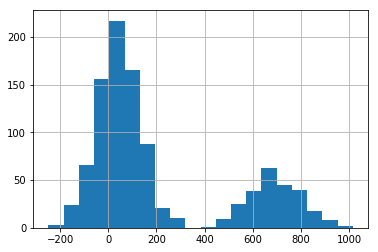

In [62]:
user_data['time_on_site'].hist(bins=20)

In [63]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,-248.32359145163946,-194.84440274685005,-186.1786698944806,-170.77109212231667,-169.14924843026515,-166.92751027520288,-165.04287498782475,-157.21540072431677,-157.1301471296292,-153.9117720172244,...,888.5228163201672,895.405323575591,903.1900821053723,904.6919883909986,912.3670374005851,917.8895281515103,931.3042632703019,946.888440768523,1008.4847402551982,1014.5614390665683
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,1,0,1,1,1,1,1,...,0,0,0,1,0,0,1,0,0,0
True,0,0,0,0,1,0,0,0,0,0,...,1,1,1,0,1,1,0,1,1,1


In [64]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(time_bins, user_data['purchased'])

purchased,False,True
time_on_site,,
"(-249.586, 4.253]",185,64
"(4.253, 256.83]",327,164
"(256.83, 509.407]",8,12
"(509.407, 761.984]",88,84
"(761.984, 1014.561]",18,50


In [65]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(time_bins, user_data['purchased'], normalize='columns')

purchased,False,True
time_on_site,,
"(-249.586, 4.253]",0.295527,0.171123
"(4.253, 256.83]",0.522364,0.438503
"(256.83, 509.407]",0.012780,0.032086
"(509.407, 761.984]",0.140575,0.224599
"(761.984, 1014.561]",0.028754,0.133690


In [66]:
pd.crosstab(time_bins, user_data['purchased'], normalize='index')

purchased,False,True
time_on_site,,
"(-249.586, 4.253]",0.742972,0.257028
"(4.253, 256.83]",0.665988,0.334012
"(256.83, 509.407]",0.400000,0.600000
"(509.407, 761.984]",0.511628,0.488372
"(761.984, 1014.561]",0.264706,0.735294


In [67]:
# That seems counter to our hypothesis
# More time on the site can actually have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.44,0.688
True,0.56,0.312


In [68]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?
pd.crosstab(time_bins, [user_data['mobile'], user_data['purchased']], normalize='columns')

mobile                  False               True           
purchased               False     True      False     True 
time_on_site                                               
(-249.586, 4.253]    0.000000  0.000000  0.358527  0.273504
(4.253, 256.83]      0.000000  0.000000  0.633721  0.700855
(256.83, 509.407]    0.036364  0.042857  0.007752  0.025641
(509.407, 761.984]   0.800000  0.600000  0.000000  0.000000
(761.984, 1014.561]  0.163636  0.357143  0.000000  0.000000

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspired by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)